### Import Required Package

In [1]:
import os
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import skimage
from PIL import Image
from skimage import color

Found GPU at: /device:GPU:0


### Install Kaggle

In [0]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [4]:
# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

### Import Flower Images

In [6]:
!kaggle datasets download -d alxmamaev/flowers-recognition
!unzip flowers-recognition.zip

 98% 442M/450M [00:06<00:00, 102MB/s] 
100% 450M/450M [00:06<00:00, 70.1MB/s]
Archive:  flowers-recognition.zip
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating: flowers/daisy/10555749515_13a12a026e.jpg  
  inflating: flowers/daisy/10555815624_

In [0]:
image_size = 256

path = './flowers/flowers'

flower_folders = [name for name in os.listdir(path) if not os.path.isdir(name)]

files = []
for folder in flower_folders:
    files.extend([os.path.join(path, folder, f) for f in os.listdir(os.path.join(path, folder)) if os.path.isfile(os.path.join(path, folder, f)) and f[-4:] == '.jpg'])
    
    
images = np.zeros([len(files), image_size, image_size, 3])

for i in range(len(files)):
    im = Image.open(files[i])
    im = im.resize((image_size, image_size), Image.ANTIALIAS)
    im = np.asarray(im)
    im = im / 255.0
    im_lab = color.rgb2lab(im)
    images[i] = im_lab


### Make images black and white

In [0]:
# Values from 0 to 100
X_images = images[:, :, :, 0]
X_images = X_images.reshape(X_images.shape[0], image_size, image_size, 1)

# Values from -128 to 128 - Convert to -1 to 1
Y_images = images[:, :, :, 1:] / 128.0

# im = bw_images[0]

# im = color.lab2rgb(im) * 255.0
# plt.imshow(im.astype('int32'))

### Create Model

In [9]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', strides = (1, 1), input_shape = (image_size, image_size, 1)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', strides = (2, 2), input_shape = (256, 256, 64)))
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', strides = (1, 1), input_shape = (128, 128, 64)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', strides = (2, 2), input_shape = (128, 128, 128)))
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', strides = (1, 1), input_shape = (64, 64, 128)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', strides = (2, 2), input_shape = (64, 64, 256)))
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), padding = 'same', strides = (1, 1), input_shape = (32, 32, 256)))
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.UpSampling2D())

model.add(keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', strides = (1, 1), input_shape = (64, 64, 512)))
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.UpSampling2D())

model.add(keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', strides = (1, 1), input_shape = (128, 128, 256)))
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.UpSampling2D())

model.add(keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', strides = (1, 1), input_shape = (256, 256, 64)))
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.Conv2D(filters = 2, kernel_size = (3, 3), padding = 'same', strides = (1, 1), input_shape = (256, 256, 64)))
model.add(keras.layers.Activation('tanh'))


model.compile(loss = 'mse', optimizer = 'adam')

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      640       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
activation_2 (Activation)    (None, 128, 128, 128)     0         
____

### Train Model

In [14]:
model.fit(X_images, Y_images, batch_size = 32, epochs = 50)

Epoch 1/50
4323/4323 [==============================] - 213s 49ms/sample - loss: 0.0298
Epoch 2/50
4323/4323 [==============================] - 213s 49ms/sample - loss: 0.0297
Epoch 3/50
4323/4323 [==============================] - 213s 49ms/sample - loss: 0.0297
Epoch 4/50
4323/4323 [==============================] - 213s 49ms/sample - loss: 0.0297
Epoch 5/50
4323/4323 [==============================] - 213s 49ms/sample - loss: 0.0295
Epoch 6/50
4323/4323 [==============================] - 213s 49ms/sample - loss: 0.0294
Epoch 7/50
4323/4323 [==============================] - 213s 49ms/sample - loss: 0.0293
Epoch 8/50
4323/4323 [==============================] - 213s 49ms/sample - loss: 0.0290
Epoch 9/50
4323/4323 [==============================] - 213s 49ms/sample - loss: 0.0294
Epoch 10/50
4323/4323 [==============================] - 213s 49ms/sample - loss: 0.0288
Epoch 11/50
4323/4323 [==============================] - 213s 49ms/sample - loss: 0.0294
Epoch 12/50
4323/4323 [=======

### Colorize Images

Original Image


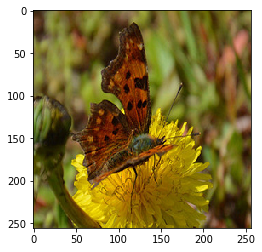

0.3608412431276403
Black and White Training Image


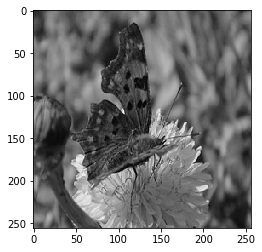

Colored Image


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 57 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


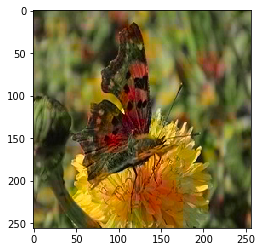

In [32]:
image_sample = np.random.randint(images.shape[0])

im = color.lab2rgb(images[image_sample])
im = im * 255.0

print('Original Image')
plt.imshow(im.astype('int32'))
plt.show()
plt.clf()


im = np.append(images[image_sample, :, :, 0].reshape(1, image_size, image_size, 1), np.zeros([1, image_size, image_size, 2]), axis = 3)
im = color.lab2rgb(im[0])
im = im * 255.0

print(np.min(im))
print('Black and White Training Image')
plt.imshow(im.astype('int32'))
plt.show()
plt.clf()


preds = model.predict(images[image_sample, :, :, 0].reshape(1, image_size, image_size, 1)) * 128.0
im = np.append(images[image_sample, :, :, 0].reshape(1, image_size, image_size, 1), preds, axis = 3)

im = color.lab2rgb(im[0])
im = im * 255.0


print('Colored Image')
plt.imshow(im.astype('int32'))